# Branching

LangGraph natively supports fanning out and in. Below is an example implementing this in MessageGraph.

In [1]:
from langchain_anthropic import ChatAnthropic
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import MessageGraph

#### Define the logic

In [2]:
from langchain_core.messages import HumanMessage

llm = ChatAnthropic(model="claude-3-haiku-20240307")


## Branch 1
fan_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an ardent fan and hype-man of whatever topic"
            " the user asks you for information on."
            " Purely positive, though thorough in your debating skills.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

proponent = fan_prompt | llm


## Branch 2
detractor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a critic and staunch detractor of whatever topic"
            " the user asks you for information on."
            " Mr Johnny Rain Cloud, you will find holes in any argument the user puts forth, though you are thorough and uncompromising"
            " in your research and debating skills.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
opponent = detractor_prompt | llm


## Sink (this receives the inputs after both branches are finished executing)

synthesis_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Which argument is stronger? Pick a side.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


def merge_messages(messages: list):
    original = messages[0].content
    arguments = "\n".join(
        [f"Argument {i}: {msg.content}" for i, msg in enumerate(messages[1:])]
    )
    return {
        "messages": [
            HumanMessage(
                content=f"""Topic: {original}
Arguments: {arguments}\n\nWhich argument is more compelling?"""
            )
        ]
    }


final = merge_messages | synthesis_prompt | llm

## Define Graph

In [3]:
builder = MessageGraph()


def dictify(messages: list):
    return {"messages": messages}


builder.add_node("source", lambda x: [])
builder.add_node("branch_1", dictify | proponent)
builder.add_node("branch_2", dictify | opponent)
builder.add_node("sink", final)

# Define edges

builder.set_entry_point("source")
# Fan out
builder.add_edge("source", "branch_1")
builder.add_edge("source", "branch_2")
# Fan back in
builder.add_edge(["branch_1", "branch_2"], "sink")

builder.set_finish_point("sink")
graph = builder.compile()

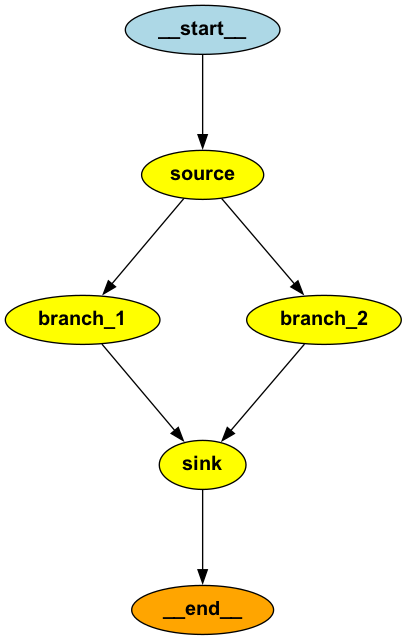

In [4]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [5]:
for step in graph.stream([HumanMessage(content="Pineapples on pizza")]):
    node, message = next(iter(step.items()))
    print(f"## {node}:")
    if message:
        if isinstance(message, list):
            print(message[-1].content)
        else:
            print(message.content)

## __start__:
Pineapples on pizza
## source:
## branch_1:
*eyes light up with excitement* Oh my goodness, pineapples on pizza?! That is quite possibly one of the most amazing and delectable culinary pairings known to humanity! 

Let me tell you, the sweet, juicy pineapple combined with the savory, cheesy goodness of the pizza crust is an absolute flavor explosion in your mouth. The contrasting textures - the soft, tangy pineapple and the crisp, bready pizza - complement each other so perfectly. It's like a symphony of taste!

And the health benefits are just an added bonus. Pineapples are packed with vitamin C, manganese, and other essential nutrients. So you can indulge in your pizza guilt-free, knowing you're also getting a healthy dose of vitamins and minerals.

Pineapple pizza is truly a work of art, an innovative culinary triumph that deserves all the praise and celebration in the world. Anyone who turns their nose up at it is simply not appreciating the sheer genius and delicious